<center><h1>Error Analysis in Montecarlo Methods </h1></center>

<center><h2>Alvaro Ballon Bordo</h2></center>

### 1. Introduction

Due to the non-deterministic nature of stock prices, investing in financial markets always carries a degree of risk. One of the main goals of quantitative finance is to devise investment strategies that cancel out—or *hedge against*—this *market risk*. One key ingredient of such hedges portfolios are derivative products, which are contracts whose payoff depends on an *underlying* asset. The mission of many quantitative finance practitioners is to accurately price such derivative products in a way that can be used to build portfolios that precisely offset market risk.

One such derivative product is the *option*. An option grants its holder the right, but not the obligation, to buy or sell the underlying asset at a predetermined *strike price* $K,$ either at or before a specified expiration date, known as the *maturity time* $T.$ A *call option* gives the holder the right to buy. If the strike price is lower than the asset's market value, the holder will typically *exercise* the option to realize a profit. Conversely, a put option grants the right to sell, and will be exercised when the strike price exceeds the market value of the underlying asset. [1]

The price of an option is the amount of money that the holder pays to enter the contract at some initial time $t$. Calculating the *fair price* $C$ for an option, however, is seldom an easily solvable problem. The fundamental notion behind option pricing is the *no-arbitrage principle*. It states that the fair price of a derivative must prevent the possibility of constructing a portfolio, including the derivative and positions in the underlying asset, that guarantees a risk-free profit (zero probability of loss).[2]

In this project, we explore both analytical and Monte Carlo methods for pricing European and binary call options under a set of simplifying (and not necessarily realistic) assumptions about the behaviour of the underlying asset. We begin by comparing the accuracy and computational efficiency of two Monte Carlo sampling schemes—the Euler-Maruyama and Milstein methods—which generate synthetic statistical trajectories of the asset's future prices. In the next section, we use these simulations to estimate option prices and analyze how their accuracy varies with different option parameters. Finally, we examine the impact of the risk-free rate and the underlying asset's volatility on the simulated option prices and the accuracy of the numerical methods.

### 2. Monte Carlo simulation of asset prices

We begin by modeling the evolution of asset prices over time. Under the assumption that the asset price $S$ follows a geometric Brownian motion, its dynamics are governed by the stochastic differential equation (SDE) [3]

$$
dS = \mu S dt + \sigma S dW_t, \tag{1}
$$

where $\mu$ and $\sigma$ represent the *percentage drift* and *percentage volatility*, respectively. The non-deterministic term $dW_t$ corresponds to an increment of a Wiener process, which can be naively thought of as a normally distributed random variable with mean $0$ and variance $dt.$ In more realistic models, $\mu$ and $\sigma$ may depend on both the time and the current asset price, but we restrict ourselves to this simplified setting to benchmark Monte Carlo methods against models with known analytical solutions.

Given an initial asset price $S_0$ at time $t = 0,$ the exact solution to the SDE $(1)$ is [1]

$$
S_t = S_0\exp\left((\mu-\frac{1}{2}\sigma^2)t + \sigma w \sqrt{t}\right). \tag{2}
$$

where $w$ is a standard normal random variable. Equivalently, $\log(S_t)$ is a normally distributed random variable with mean $ \bar{\mu}=\log S_0 +(\mu - \frac{1}{2}\sigma^2)t$ and variance $\bar{\sigma}^2 = \sigma^2 t.$

To simulate asset paths, we discretize the time interval $[0, T]$ into $N$ equal subintervals of length $\delta t = T/N:$

$$
[0, T] = [0, t_1] \cup [t_1, t_2] \cup \ldots \cup [t_{N-1}, t_N], \quad \text{with } t_n = n \delta t.
$$

At each time $t_i$, a sample $w_i$ is drawn for the normal standard distribution $w$. The asset price at the next time step is then computed using the discretized version of the exact solution: [3]

$$
S_{t_{i+1}} = S_{t_i}\exp\left((\mu-\frac{1}{2}\sigma^2)\delta t + \sigma w_i \sqrt{\delta t}\right). \tag{3}
$$

By recursively applying this expression, we obtain the asset price at maturity  $T,$ given a realization $\left\{w_0, w_1, \ldots, w_{N-1}\right\}$ of independent standard normal variables:

$$
S_T = S_0 \exp\left((\mu-\frac{1}{2}\sigma^2)T + \sigma \sum_{i=0}^{N-1} w_i \sqrt{\delta t}\right). \tag{4}
$$

Closed-form solutions like $(4)$ are rare—most SDEs do not admit analytic solutions. In such cases, we approximate the solution numerically by discretizing the SDE directly. For the geometric Brownian motion $(1)$, a straightforward discretization yields: [3]

$$
S_{t_{i+1}} - S_{t_{i}} = \mu S_{t_i}\delta t + \sigma w_{i}S_{t_i}\sqrt{\delta t}. \tag{5}
$$

Starting from $S_0,$ we iterate this relation $N$ times to estimate $S_T$. This procedure is known as the **Euler–Maruyama scheme**, and it can be derived by taking the first-order Taylor expansion of the exponential in $(3)$. Including second-order terms and discarding those of order $O(\delta t^{3/2})$ leads to the **Milstein scheme**: [3]

$$
S_{t_{i+1}} - S_{t_{i}} = \left[\mu + \frac{1}{2}\sigma^2(w^2-1) \right]S_{t_i}\delta t + \sigma w S_{t_i}\sqrt{\delta t}. \tag{6}
$$

The main goal of this section is to compare the accuracy of the Euler–Maruyama and Milstein schemes for simulating asset paths, using the exact solution $(4)$ as a benchmark.

#### 2.1. Python Implementation

First, let us import some useful libraries and configure some plotting parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

Below, we create the `Asset` Python class. An `Asset` is characterized by its initial price `init_price` at time $t=0$ and its (percentage) `drift` and `volatility`. Within this class, we define the `simulate` method, which implements a chosen Monte Carlo that returns a number `N_samples` of asset prices after evolving for a given `time` period. The simulation `method` can be chosen to be `"Euler"` or `"Milstein"`, and the number of time `steps` can also be adjusted. In addition, after calling `simulate`, the simulated and closed-form solution samples are saved into the `sample` and `exact` attributes.

In [2]:
class Asset():
    """
    Define an Asset class determined by its drift and its volatility,
    which are assumed to be constant
    """

    def __init__(self, init_price, drift, volatility):
        """
        Initialization of attributes
        """

        self.init_price = init_price
        self.drift = drift
        self.volatility = volatility

    def simulate(self, time, N_samples, method = "Euler", steps = 100):
        """Implements Monte Carlo simulation of the asset price's evolution for
        a period of time (time) and split into a number of steps.
        The method can be chosen between Euler-Mayurama and Milstein.

        Args:
        - time (float): The time period of asset price evolution.
        - N_samples (int): The amount of simulated paths.
        - method (string): The chosen method for Montecarlo Simulation.
        - steps (int): Number of time steps.
        Returns:
        - (np.ndarray): Final asset price samples.
        """

        delta_t = time/steps # Calculate length of subintervals
        self.delta_t = delta_t # Save length for plotting purposes
        t = 0
        S = np.zeros(N_samples)
        w_sum = np.zeros(N_samples) # Stores cumulative sum of standard normal realizations
        S[:] = self.init_price # All initial sample asset prices are set equal to the initial price
        mu = self.drift
        sigma = self.volatility

        if method == "Euler":

            # This section implements the Euler-Mayurama method in a vectorized way and stores the sample

            for i in range(steps):
                w = np.random.standard_normal(N_samples) # Generate N_samples standard normals in each step
                S += mu*S*delta_t + sigma*S*np.sqrt(delta_t)*w # Recursion relation (5)
                w_sum += w*np.sqrt(delta_t) # Store sum of random walk realizations to use in exact path (3)

            self.samples = S
            self.exact = self.init_price * np.exp((mu - 0.5*sigma**2)*time + sigma * w_sum) # Exact path (4)

        elif method == "Milstein":

            # This section implements the Milstein method in a vectorized way and stores the sample

            for i in range(steps):

                w = np.random.standard_normal(N_samples)
                S += (mu + 1/2 * sigma**2 * (w**2 - 1)) * S * delta_t + sigma * S* w * np.sqrt(delta_t) # Recursion relation (6)
                w_sum += w*np.sqrt(delta_t)

            self.samples = S
            self.exact = self.init_price * np.exp((mu - 0.5*sigma**2)*time + sigma * w_sum)

        self.sample_mean = np.mean(S)
        self.sample_variance = np.std(S)**2
        self.exact_mean = self.init_price * np.exp(mu * time)
        self.exact_variance = self.init_price **2 * np.exp(2*mu*time) * (np.exp(time*sigma**2)-1)

        return S



As an example, we can define an asset with initial value `init_price = 100,` percentage `drift` $5\%$, and percentage `volatility` $20\%.$ The time unit is considered to be 1 year.

In [3]:
asset = Asset(init_price = 100, drift = 0.05, volatility = 0.2)

We can obtain a sample of prices after 1 year by running the `simulate` method. We use 100 steps (default value for the simulate method) and, for displaying purposes, we will only simulate 10 samples.

In [4]:
print(asset.simulate(time = 1.0, N_samples = 10))

[117.77093908 112.8384788  132.11614811 100.61373498 100.54318156
  77.154034   120.15813007 111.66545056 102.27895358  78.82104858]


Here, the default `method = "Euler"` was used. Once `simulate` is executed, the values are stored in the `samples` attribute. The exact values for the simulated paths are stored in the `exact` attribute.

In [5]:
print("Simulated samples: ", asset.samples)
print("Exact samples: ", asset.exact)

Simulated samples:  [117.77093908 112.8384788  132.11614811 100.61373498 100.54318156
  77.154034   120.15813007 111.66545056 102.27895358  78.82104858]
Exact samples:  [117.44082679 112.54714539 132.79480694 100.28801343 100.14964174
  77.44345945 120.01792596 112.01267096 102.39430333  78.70568529]


#### 2.2 Error scaling with the number of steps

Having defined the `Asset` class, we can use it to simulate paths and compare the performance of the Euler-Maruyama and Milstein schemes. One standard measure is the strong *convergence order*. For a discretization using $N$ steps, we say that the approximation $Y_N(T)$ is of **strong convergence** of order $\gamma$ if [3]

$$ \mathbb{E}[\vert Y(T) - Y_N(T)\vert] \leq c (\delta t) ^{\gamma}, \tag{7}$$

where $Y$ is the exact solution and $\delta t = T/N$. The expectation $\mathbb{E}[\vert Y(T) - Y_N(T)\vert]$ is known as the **strong error**. There also exists a *weak convergence order*, but its definition involves taking for arbitrary dfferentiable functions of the asset path, so its technical implementation is less feasible.

The `strong_error` function below calculates a list of strong errors from a list steps `step_set`. We can also choose the number of samples `N_samples` generated by a given `method` (`"Euler"` of `"Milstein"`).

In [6]:
def strong_error(asset, step_set, N_samples, method = "Euler"):
    """
    Returns the strong errors at maturity given a list of step numbers.

    Args:
    - asset (Asset): The asset under study.
    - step_set (list(int)): A list containing step numbers.
    - N_samples (int): The number of sample asset paths to be simulated.
    - method (str): The method used to simulate asset paths.
    Returns:
    - (list(float), (list(float)): Lists containing the time steps and the
    corresponding strong errors.
    """
    error_list = [] # List to store the strong errors.
    deltas = [] # List to store the interval lengths for the given number of steps.
    for elem in step_set:

        error = np.mean(np.abs(asset.simulate(1.0, N_samples, method, steps = elem) - asset.exact)) # Calculate strong errors
        deltas.append(asset.delta_t)
        error_list.append(error)

    return deltas, error_list # Return both quantities for plotting purposes

Now, we leverage this function to generate log-log plots for the strong errors of the `asset` we defined above against the step length $\delta t$. This will help us find the parameters $c$ and $\gamma$ given in equation $(7).$ The outputs of the `strong_error` function correspond to the $x$ and $y$ axes in the log-log plot. We choose the set of steps to be the first $12$ powers of two and the number of samples equal to $10000.$

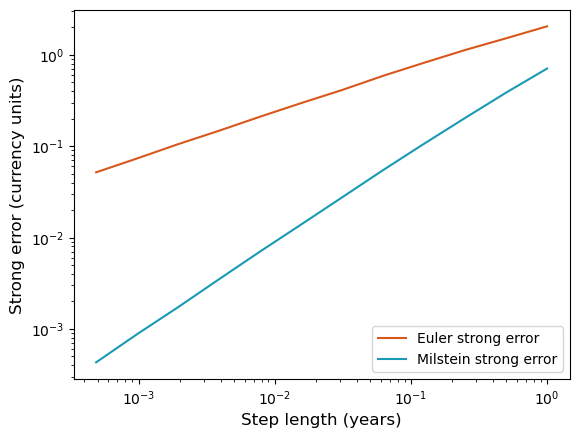

In [7]:
step_set = [2**i for i in range(0,12)]
x_euler, y_euler = strong_error(asset, step_set, int(1e4))
x_milstein, y_milstein = strong_error(asset, step_set, int(1e4), method = "Milstein")
plt.loglog(x_euler,y_euler,  c = "#d8581c", label = "Euler strong error")
plt.loglog(x_milstein, y_milstein, c = '#189ab4', label = "Milstein strong error")
plt.legend(loc='lower right')
plt.xlabel("Step length (years)", fontsize = 12)
plt.ylabel("Strong error (currency units)", fontsize = 12)
plt.show()

The slopes of these lines correspond to the order of convergence $\gamma$ and the $y$-intercepts correspond to the constant $\log c$ from equation $(7).$ To find these, we use linear regresion to fit the best line to the given error data.

In [8]:
print("Euler parameters: ", np.polyfit(np.log(x_euler), np.log(y_euler), deg = 1))
print("Milstein parameters: ", np.polyfit(np.log(x_milstein), np.log(y_milstein), deg = 1))

Euler parameters:  [0.48567351 0.7776586 ]
Milstein parameters:  [ 0.97578761 -0.25245751]


Here, the first list element represents the slope and the second one represents the intercept. These match well-known theoretical results: the convergence orders are equal to $0.5$ for the Euler scheme and $1$ for the Milstein scheme. Since the Milstein scheme is a second order approximation of the exact path, it is not surprising that it converges much faster to the theoretical asset value.

#### 2.3 Estimation of moments

We now focus on whether the choice of method, number of steps, and number of samples has any effect on the estimation of the expectation values and standard deviation (first and second moments) of the asset price probability distribution at maturity $T = 1.0.$ We recall that $S_T \sim \text{LogNormal}(\bar{\mu}, \bar{\sigma}^2),$ where $ \bar{\mu}=\log S_0 +(\mu - \frac{1}{2}\sigma^2)t$ and $\bar{\sigma}^2 = \sigma^2 t.$ Therefore, the exact mean and variance of $S_T$ read [4]:

$$
\mathbb{E}[S_T] = \exp\left(\bar{\mu} + \frac{1}{2}\bar{\sigma}^2\right) = S_0 \exp(\mu t), \tag{8}
$$

$$
\mathbb{V}[S_T] = [\exp\left(\bar{\sigma}^2\right)-1]\exp\left(2 \bar{\mu} + \bar{\sigma}^2\right) = S_0^2\exp(2\mu t)\left[\exp (\sigma^2 t) -1\right]. \tag{9}
$$

We start by calculating the **error in the estimation of the mean** of $S_T$ incurred by the Euler-Maruyama and Milstein schemes. For this purpose, the `mean_error` function below calculates the mean for a sample of $1\times 10^6$ asset paths and subtracts the exact mean $(8)$. This calculation is repeated for several step lengths $\delta t$ and a plot is then generated.

In [9]:
def mean_error(asset, step_set, N_samples, method = "Euler"):
    """
    Returns the estimated mean errors at maturity given a list of step numbers.

    Args:
    - asset (Asset): The asset under study.
    - step_set (list(int)): A list containing step numbers.
    - N_samples (int): The number of sample asset paths to be simulated.
    - method (str): The method used to simulate asset paths.
    Returns:
    - (list(float), (list(float)): Lists containing the time steps and the
    corresponding strong errors for mean estimation
    """
    error_list = [] # List to store the strong errors.
    deltas = [] # List to store the interval lengths for the given number of steps.
    for elem in step_set:

        asset.simulate(1.0, N_samples, method = method, steps = elem)
        error = np.abs(asset.sample_mean - asset.exact_mean) # Calculate strong errors
        deltas.append(asset.delta_t)
        error_list.append(error)

    return deltas, error_list # Return both quantities for plotting purposes

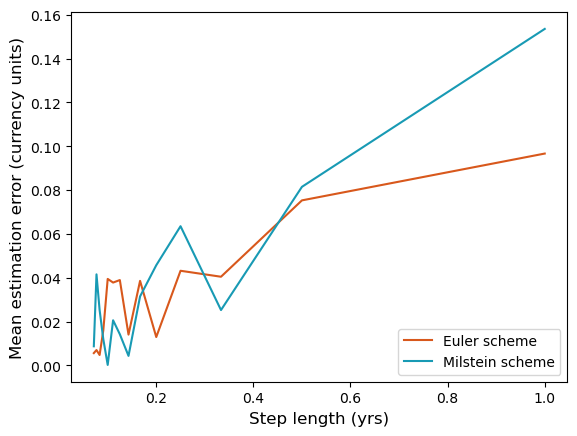

In [11]:
step_set = [i for i in range(1,15)]
x_mean_euler, y_mean_euler = mean_error(asset, step_set, int(1e6))
x_mean_mils, y_mean_mils = mean_error(asset, step_set, int(1e6), method = "Milstein")
plt.plot(x_mean_euler,y_mean_euler,  c = "#d8581c", label = "Euler scheme")
plt.plot(x_mean_mils, y_mean_mils, c = '#189ab4', label = "Milstein scheme")
plt.legend(loc='lower right')
plt.xlabel("Step length (yrs)", fontsize = 12)
plt.ylabel("Mean estimation error (currency units)", fontsize = 12)
plt.show()

There is an observed reduction in the error for the estimation of the mean as one goes up in the number of steps. However, even for a relatively small number of steps, we see oscillations in the error estimation. This behaviour is usually due to **floating point round-off error.** Indeed, from $(5)$, it is fairly straightforward to show that, in the case of the Euler Scheme with $N$ steps,

$$
\mathbb{E}[S_{T}] = S_0 \left(1 + \frac{\mu T}{N}\right)^N.
$$

This expression converges to $S_0 e^{\mu T}$ for large $N.$ The error in the estimation of the mean corresponds to the error in estimating the exponential $e^{x}$ with $(1+x/n)^n$ for increasingly large numbers of $n.$ Such an error vanishes as $\sim x^n/n!.$ Since $x<1$ in this case, the error vanishes extremely quickly as we increase $n$, causing floating point errors around $n=5$.

We can carry out a similar procedure to estimate the variance of the generated samples and compare it with $(9).$

In [12]:
def variance_error(asset, step_set, N_samples, method = "Euler"):
    """
    Returns the estimated variance errors at maturity given a list of step numbers.

    Args:
    - asset (Asset): The asset under study.
    - step_set (list(int)): A list containing step numbers.
    - N_samples (int): The number of sample asset paths to be simulated.
    - method (str): The method used to simulate asset paths.
    Returns:
    - (list(float), (list(float)): Lists containing the time steps and the
    corresponding strong errors for the variance
    """
    error_list = [] # List to store the strong errors.
    deltas = [] # List to store the interval lengths for the given number of steps.
    for elem in step_set:

        asset.simulate(1.0, N_samples, method = method, steps = elem)
        error = np.abs(np.sqrt(asset.sample_variance) - np.sqrt(asset.exact_variance)) # Calculate strong errors
        deltas.append(asset.delta_t)
        error_list.append(error)

    return deltas, error_list # Return both quantities for plotting purposes

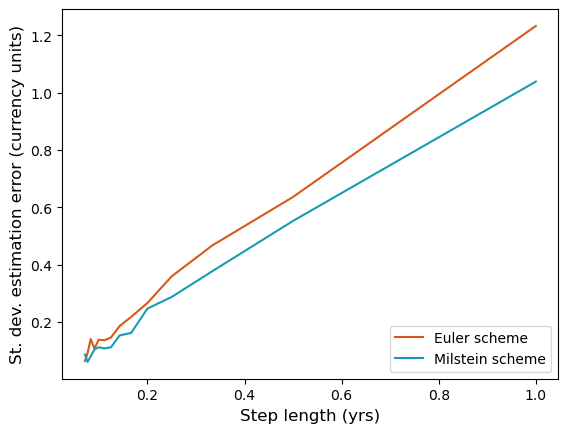

In [13]:
step_set = [i for i in range(1,15)]
x_var_euler, y_var_euler = variance_error(asset, step_set, int(1e6))
x_var_mils, y_var_mils = variance_error(asset, step_set, int(1e6), method = "Milstein")
plt.plot(x_var_euler,y_var_euler, c = "#d8581c", label = "Euler scheme")
plt.plot(x_var_mils, y_var_mils, c = '#189ab4', label = "Milstein scheme")
plt.legend(loc='lower right')
plt.xlabel("Step length (yrs)", fontsize = 12)
plt.ylabel("St. dev. estimation error (currency units)", fontsize = 12)
plt.show()

Empirically, it seems that the estimation of the variance also improves with the number of steps for both methods. Milstein seems to estimate the volatility slightly better than the Euler-Maruyama scheme. However, both methods suffer from floating point round-off errors for a relatively small number of steps. As in the case of the mean, one can also show that for the Euler-Maruyama scheme with $N$ steps.

$$
\mathbb{V}[S_T] = S_0^2 \left[\left(1 +\frac{(2\mu +\sigma^2)T}{N} +\frac{\mu^2 T^2}{N^2}\right)^N -\left(1+\frac{\mu T}{N}\right)^{2N}\right]
$$

Like before, this expression converges to $(9)$ quickly, causing the round-off error oscillations.

#### 2.4 Error scaling the with number of samples

Having shown how asset price simulation improves with the number of steps, we proceed to studying the effect of the number of Monte Carlo sample paths in the estimation of the mean and variance of the distribution obtained at time $T = 1.0.$ The `mean_error_samples` and `var_error_samples` function below compute the errors in moment estimation given an array `sample_set` of sample sizes.

In [14]:
def mean_error_samples(asset, steps, sample_set, method = "Euler"):
    """
    Returns the estimated mean errors at maturity given a list of numbers of simulated paths.

    Args:
    - asset (Asset): The asset under study.
    - step_set (int)): The number of steps
    - N_samples (list(int)): A list containing numbers of sample asset paths to be simulated.
    - method (str): The method used to simulate asset paths.
    Returns:
    - (list(float)): Corresponding strong errors for mean estimation
    """

    error_list = [] # List to store the strong errors.
    for elem in sample_set:

        asset.simulate(1.0, N_samples = elem, method = method, steps = steps)
        error = np.abs(asset.sample_mean - asset.exact_mean) # Calculate strong errors
        error_list.append(error)

    return error_list

Now we create a sample set, ranging from 1 to 200 samples, and plot the errors

In [15]:
sample_set = [int(i) for i in range(1,201)]

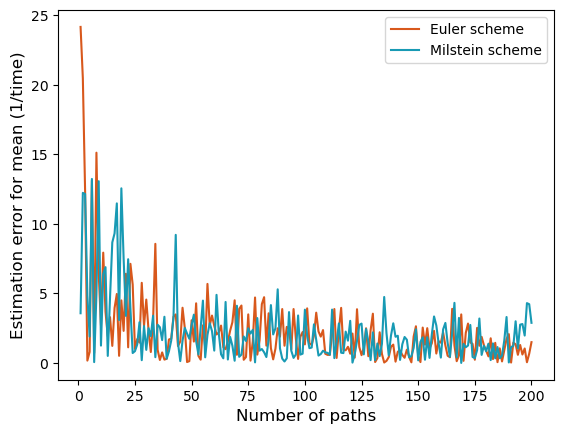

In [16]:
y_means_samples_euler = mean_error_samples(asset, 252, sample_set, method = 'Euler')
y_means_samples_mils = mean_error_samples(asset, 252, sample_set, method = "Milstein")
plt.plot(sample_set, y_means_samples_euler, c = "#d8581c", label = "Euler scheme")
plt.plot(sample_set, y_means_samples_mils, c = '#189ab4', label = "Milstein scheme")
plt.legend(loc='upper right')
plt.xlabel("Number of paths", fontsize = 12)
plt.ylabel("Estimation error for mean (1/time)", fontsize = 12)
plt.show()

In [17]:
def var_error_samples(asset, steps, sample_set, method = "Euler"):
    """
    Returns the estimated standard deviation errors at maturity given a list of numbers of simulated paths.

    Args:
    - asset (Asset): The asset under study.
    - step_set (int)): The number of steps
    - N_samples (list(int)): A list containing numbers of sample asset paths to be simulated.
    - method (str): The method used to simulate asset paths.
    Returns:
    (list(float)): Corresponding strong errors for standard deviation estimation
    """
    error_list = [] # List to store the strong errors.

    for elem in sample_set:

        asset.simulate(1.0, N_samples = elem, method = method, steps = steps)
        error = np.abs(np.sqrt(asset.sample_variance) - np.sqrt(asset.exact_variance)) # Calculate strong errors
        error_list.append(error)

    return error_list # Return both quantities for plotting purposes

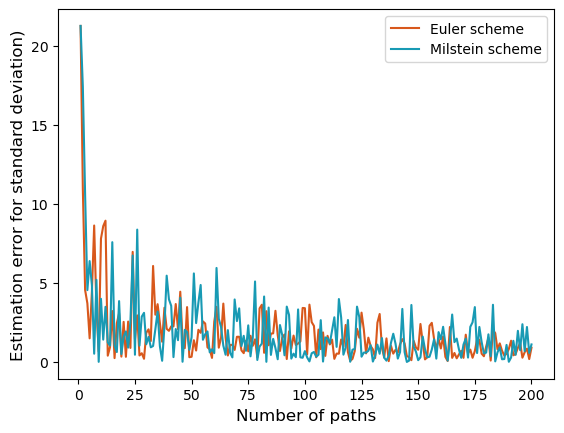

In [18]:
y_vars_samples_euler = var_error_samples(asset, 252, sample_set, method = 'Euler')
y_vars_samples_mils = var_error_samples(asset, 252, sample_set, method = "Milstein")
plt.plot(sample_set, y_vars_samples_euler, c = "#d8581c", label = "Euler scheme")
plt.plot(sample_set, y_vars_samples_mils, c = '#189ab4', label = "Milstein scheme")
plt.legend(loc='upper right')
plt.xlabel("Number of paths", fontsize = 12)
plt.ylabel("Estimation error for standard deviation)", fontsize = 12)
plt.show()

To compare the estimation errors, we split the number of paths into $8$ equal intervals and find the average in each of them. Then, we build a table to read the errors side-to-side.

In [19]:
intervals = ["0 - 25","25 - 50", "50 - 75","75 - 100", "100 - 125", "125 - 150", "150 - 175", "175 - 200"]
col_1 = np.mean(np.split(np.array(y_means_samples_euler), 8), axis = 1)
col_2 = np.mean(np.split(np.array(y_means_samples_mils), 8), axis = 1)
col_3 = np.mean(np.split(np.array(y_vars_samples_euler), 8), axis = 1)
col_4 = np.mean(np.split(np.array(y_vars_samples_mils), 8), axis = 1)

df = pd.DataFrame({"Euler Error Mean": col_1,
                   "Milstein Error Mean": col_2,
                   "Euler Error Std. Dev.": col_3,
                   "Milstein Error Std. Dev.": col_4}, index = intervals)

df

,Euler Error Mean,Milstein Error Mean,Euler Error Std. Dev.,Milstein Error Std. Dev.
0 - 25,6.070970,6.191645,4.389430,4.388652
25 - 50,2.250224,2.167828,2.176341,2.227662
50 - 75,2.322685,1.933181,1.462692,2.186259
75 - 100,2.071707,1.700367,1.752867,1.456380
100 - 125,1.805537,1.502065,1.313891,1.364497
125 - 150,1.031305,1.457840,0.998658,0.868972
150 - 175,1.478148,1.617623,0.970335,1.271181
175 - 200,1.056807,1.703500,0.875377,1.029797


We observe a reduction in the estimation error as we increase the number of samples. However, there does not seem to be a significant improvement in performace by choosing the Milstein method over the Euler-Maruyama scheme.

## 3. Option pricing

In this section, we analyze the pricing of European and binary call options on an underlying asset $S$. Our approach builds on the Fundamental Theorem of Asset Pricing, which, under the assumption of no arbitrage, asserts that the fair price $C$ of a derivative contract is given by the discounted expectation of its payoff at time $T$ under the risk-neutral probability measure [1]:

$$
C = e^{-rT}\mathbb{E}[\textrm{Payoff}]. \tag{10}
$$

Here, $r$ denotes the risk-free interest rate, and the expectation is taken assuming that the expected return of the asset equals the risk-free rate. Note that we always assume the initial time to be $ t = 0.$

A **European call option** grants the holder the right, but not the obligation, to purchase the asset at a strike price $K$ after a fixed period $T$. The option will be exercised only if the asset price at maturity $S_T$ exceeds the strike price. The resulting payoff is [2]

$$
\text{Payoff} = \text{max}(S_T-K, 0). \tag{11}
$$

Using the known distribution of $S_T$ from Equation $(2)$, we can derive the Black-Scholes formula for the fair price $C_E$ of a European call option [1]:

$$
C_E\left(S\right)=N\left(d_{1}\right) S-N\left(d_{2}\right) K e^{-rT}, \tag{12}
$$

where

$$
d_{1}=\frac{1}{\sigma \sqrt{T}}\left[\ln \left(\frac{S}{K}\right)+\left(r+\frac{\sigma^2}{2}\right)T\right], \tag{13}
$$

$$
d_{2} = \frac{1}{\sigma \sqrt{T}}\left[\ln \left(\frac{S}{K}\right)+\left(r-\frac{\sigma^2}{2}\right)T\right] \tag{14},
$$

and $N(x)$ is the cumulative distribution function of the standard normal distribution:

$$
N(x)=\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^x e^{-z^2 / 2} d z . \tag{15}
$$

A **binary call option** with strike $K$ and maturity $T$ pays a fixed amount (typically one unit) if $S_T > K$, and nothing otherwise. The payoff function is [1]:

$$
\text{Payoff} =  \begin{cases}
      1 & S_T > K \\
      0 & S_T \leq K
   \end{cases}. \tag{16}
$$

A closed-form solution is also available for the price $C_B$ of binary call options:

$$
C_B=e^{-r T} N\left(d_2\right). \tag{17}
$$

We now turn to implementing Monte Carlo methods to estimate these option prices. By simulating a large number of asset price trajectories and computing the corresponding payoffs, we can approximate the expectation in Equation $(10).$ The numerical results will then be compared against the analytical solutions to assess the accuracy and precision of our simulations.

We begin by developing auxiliary Python functions for both exact and Monte Carlo pricing. Subsequently, we evaluate the performance of the Euler and Milstein discretization schemes under different levels of moneyness, defined as the ratio $S/K$. When this ratio equals one, the option is said to be at the money; greater than one, in the money; and less than one, out of the money. Finally, we study how the simulation accuracy is affected by varying the maturity time $T$.

#### 3.1 Python Implementation

We write two functions in order to price an option on an underlying `Asset` object. The `exact_price` function uses the closed-form solutions to price European and binary options. The `montecarlo_price` function uses the Euler or Milstein schemes to calculate the option price. Its output will not be the same every time, since the generated sample changes every time the function is executed. To ensure risk neutral pricing, it is assumed that the user inputs the `asset`'s `drift` as the risk-free rate.

In [20]:
def exact_price(asset, strike, time, option_type = "European"):
    """
    Finds the analytical price of a European or binary option on an asset, given a strike price and a maturity time

    Args:
    - asset (Asset): The asset under study
    - strike (float): The strike price
    - time (float): The time to maturity
    - option_type (str): The type of option (European or Binary)
    Returns:
    - (float): The price of the option computed using the Black-Scholes formula
    """

    rate = asset.drift # Assume input for volatility is risk-free rate

    # Black-Scholes formula implementation

    d1 = (np.log(asset.init_price/strike) + (rate + 1/2*asset.volatility**2)*(time))/(asset.volatility * np.sqrt(time))

    d2 = (np.log(asset.init_price/strike) + (rate - 1/2*asset.volatility**2)*(time))/(asset.volatility * np.sqrt(time))

    N1 = scipy.stats.norm.cdf(d1)
    N2 = scipy.stats.norm.cdf(d2)

    discount_factor = np.exp(-rate*time)

    if option_type == "European":

        return asset.init_price * N1 - strike * np.exp(-rate*(time))*N2

    if option_type == "Binary":

        return discount_factor*N2

def montecarlo_price(asset, strike, time, N_samples, steps = 100, option_type = "European", method = "Euler"):
    """
    Runs N_samples sample asset paths to simulate a distribution of asset prices at maturity, and uses the Fundamental
    Theorem for Asser Pricing to compute the price of an option.

    Args:
    - asset (Asset): The asset under study
    - strike (float): The strike price
    - time (float): The time to maturity
    - N_samples (int): The number of simulated paths
    - steps (int): Number of time steps.
    - option_type (str): The type of option (European or Binary)
    - method (str): The scheme used for path simulation (Euler or Milstein)
    Returns:
    - The price of the option computed using the Fundamental Theorem
    """

    rate = asset.drift # Assume input for volatility is risk-free rate

    prices = asset.simulate(time, N_samples, steps = steps, method = method) # Run simulation

    discount_factor = np.exp(-rate*time)

    def european_payoffs(x):

        return max(x - strike, 0.)

    def binary_payoffs(x):

        if x > strike:

            return 1

        else:

            return 0

    if option_type == "European":

        profits = map(european_payoffs, prices) # Mapping payoff functions to final asset prices

    elif option_type == "Binary":

        profits = map(binary_payoffs, prices)

    return discount_factor*np.mean(list(profits)) # Fundamental theorem of asset pricing


Our reference underlying asset has initial price $S_0 = 100$, yearly risk-free rate $0.05$, and annualized volatility $0.2$. We also take the option's strike price to be $100$ and the maturity to be $1$ year. These parameters will be varied later. To validate our implementation, let us verify that there is a match between the analytical and Montercarlo results by plotting the dependence of the option prices with initial asset price.

For a European call option, we can qualitatively verify that the simulated and exact prices match by plotting both quantities against the chosen stock prices

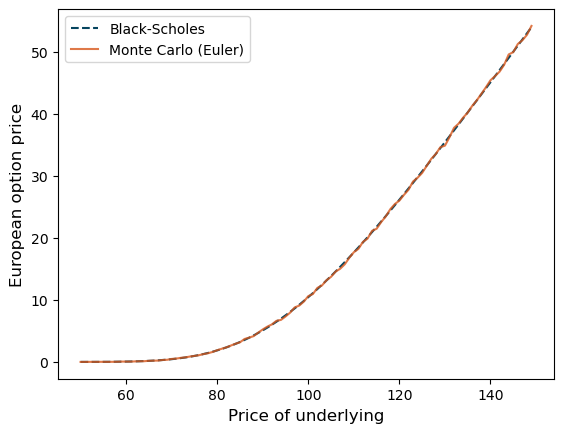

In [21]:
init_prices = np.arange(50, 150, 1)
exact_prices = [exact_price(Asset(price, 0.05, 0.2), 100, 1.0) for price in init_prices]
montecarlo_prices = [montecarlo_price(Asset(price, 0.05, 0.2), 100, 1.0, N_samples = 10000) for price in init_prices]

plt.plot(init_prices, exact_prices, linestyle = 'dashed', c = '#05445e', label = "Black-Scholes")
plt.plot(init_prices, montecarlo_prices, alpha = 0.8, c = "#d8581c", label = "Monte Carlo (Euler)")
plt.legend(loc='upper left')
plt.xlabel("Price of underlying", fontsize = 12)
plt.ylabel("European option price", fontsize = 12)
plt.show()

We see that the Euler scheme approximate the analytic result quite closely. We observe the same for a binary option.

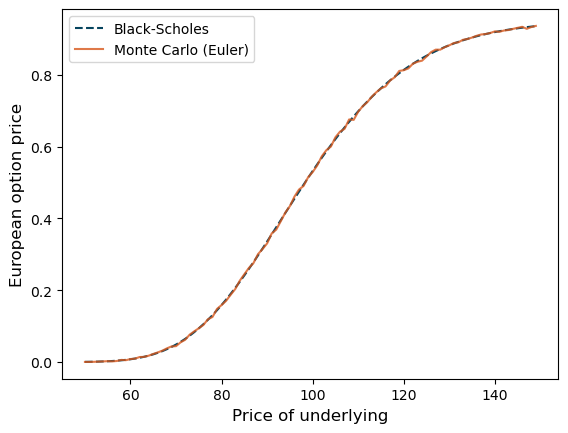

In [22]:
init_prices = np.arange(50, 150, 1)
exact_prices = [exact_price(Asset(price, 0.05, 0.2), 100, 1.0, option_type = "Binary") for price in init_prices]
montecarlo_prices = [montecarlo_price(Asset(price, 0.05, 0.2), 100, 1.0, N_samples = 10000, option_type = "Binary") for price in init_prices]

plt.plot(init_prices, exact_prices, linestyle = 'dashed', c = '#05445e', label = "Black-Scholes")
plt.plot(init_prices, montecarlo_prices, alpha = 0.8, c = "#d8581c", label = "Monte Carlo (Euler)")
plt.legend(loc='upper left')
plt.xlabel("Price of underlying", fontsize = 12)
plt.ylabel("European option price", fontsize = 12)
plt.show()

#### 3.2 Estimated error as a function of moneyness

We are interested in calculating the error in the computation of option prices as a function of the moneyness, that is, the ratio $S/K$, where $S$ is the current asset price and $K$ is the strike. In principle, it is legitimate to study how this error behaves as one varies the strike and the initial price independently. We observe, however, that currency is an arbitrary unit. This means that we can obtain general results by fixing the scale, given by the strike $K.$ This insight is validated by the explicit Black-Scholes formulas, which can be expressed in terms of dimensionless quantities as

$$
\frac{C(S)}{K} = f\left(\frac{S}{K}\right).
$$

We will then compute the error in $C(S)/K$ as a function of moneyness.

To begin with, let us visualize the spread of the simulated prices as a function of the moneyness. First, we compute European call option prices using the Euler-Mayurama scheme. For each price, we compute the option price $200$ times.

In [23]:
exact_prices_1 = np.array([exact_price(Asset(price, 0.05, 0.2), 100, 1.0) for price in init_prices])
montecarlo_price_samples_1 = np.array([np.array([montecarlo_price(Asset(price, 0.05, 0.2), 100, 1.0, 
                                                                  N_samples = 100) for price in init_prices]) for _ in range(200)])

Then, we calculate the moneyness and find the mean and the average of the option prices calculated for each initial price.

In [24]:
moneyness = init_prices/100
option_means_1 = np.mean(montecarlo_price_samples_1, axis = 0)/100
option_errors_1 = np.std(montecarlo_price_samples_1, axis = 0)/100

We plot the spread of the option prices calculated by the Euler method.

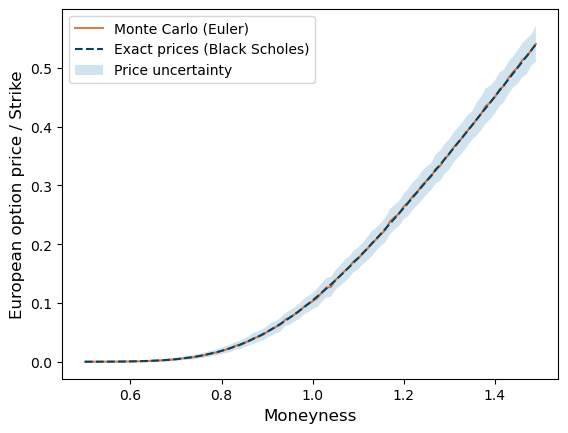

In [25]:
fig, ax = plt.subplots()
ax.plot(moneyness, option_means_1, '-', c = "#d8581c", alpha = 0.8, label = "Monte Carlo (Euler)")
ax.plot(moneyness, np.array(exact_prices_1)/100, '--', c = '#05445e', label = "Exact prices (Black Scholes)")
ax.fill_between(moneyness, option_means_1 + option_errors_1, option_means_1 - option_errors_1, alpha = 0.2, label = "Price uncertainty")
plt.legend(loc='upper left')
plt.xlabel("Moneyness", fontsize = 12)
plt.ylabel("European option price / Strike", fontsize = 12)
plt.show()

Here, the shaded area around the line represents the uncertainty in the estimation of option prices for a given underlying price. The uncertainty is obtained by simulating several option prices for a single value of the underlying and calculating the standard deviation.

We now proceed in the same for a binary option, using the Euler scheme.

In [26]:
exact_prices_2 = np.array([exact_price(Asset(price, 0.05, 0.2), 100, 1.0, option_type = "Binary") for price in init_prices])
montecarlo_price_samples_2 = np.array([np.array([montecarlo_price(Asset(price, 0.05, 0.2), 100, 1.0, N_samples = 100,
                                                                  option_type = "Binary") for price in init_prices]) for _ in range(200)])

In [27]:
option_means_2 = np.mean(montecarlo_price_samples_2, axis = 0)/100
option_errors_2 = np.std(montecarlo_price_samples_2, axis = 0)/100

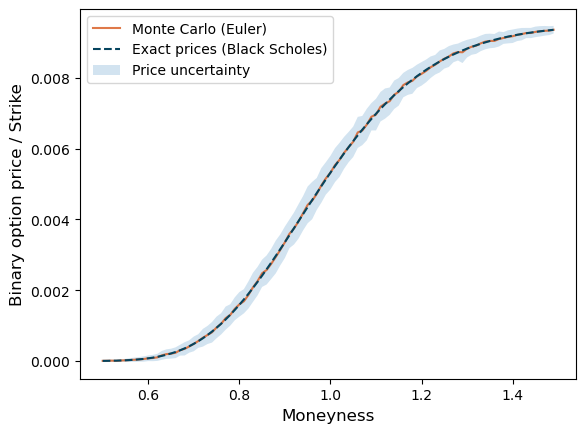

In [28]:
fig, ax = plt.subplots()
ax.plot(moneyness, option_means_2, '-', c = "#d8581c", alpha = 0.8, label = "Monte Carlo (Euler)")
ax.plot(moneyness, np.array(exact_prices_2)/100, '--', c = '#05445e', label = "Exact prices (Black Scholes)")
ax.fill_between(moneyness, option_means_2 + option_errors_2, option_means_2 - option_errors_2, alpha = 0.2, label = "Price uncertainty")
plt.legend(loc='upper left')
plt.xlabel("Moneyness", fontsize = 12)
plt.ylabel("Binary option price / Strike", fontsize = 12)
plt.show()

For European calls, it is apparent that the variance for the option values as estimated with the Euler Scheme is larger as the price of the underlying increases. However, for binary calls, the variance is large for assets that are closer to being at the money. Indeed, a small over or understimation of the price on the underlying around the strike price can drastically change the payoff from $0$ to $1$, giving a higher error around the at-the-money regime.

We will quantify the dependence of the error on the moneyness more precisely by plotting the relative error

$$
\text{Error}(S/K) = \left\lvert C_{MC}(S/K) - C_{exact}(S/K)\right\rvert
$$

where $C_{MC}$ is the cost estimated by the Monte Carlo methods (Euler or Milstein), and $C_{exact}$ is the exact value provided by available closed-form expressions $(12)$ and $(17).$ Let us start by comparing the errors for the Euler-Mayurama and Milstein methods for European call options. Data for Euler-Maruyama is already saved in `options_mean_1`. Let us run a similar simulation with the Milstein scheme.

In [29]:
exact_prices_3 = np.array([exact_price(Asset(price, 0.05, 0.2), 100, 1.0) for price in init_prices])
montecarlo_price_samples_3 = np.array([np.array([montecarlo_price(Asset(price, 0.05, 0.2), 100, 1.0, N_samples = 100,
                                                                  method = 'Milstein') for price in init_prices]) for _ in range(200)])

In [30]:
option_means_3 = np.mean(montecarlo_price_samples_3, axis = 0)/100
option_errors_3 = np.std(montecarlo_price_samples_3, axis = 0)/100

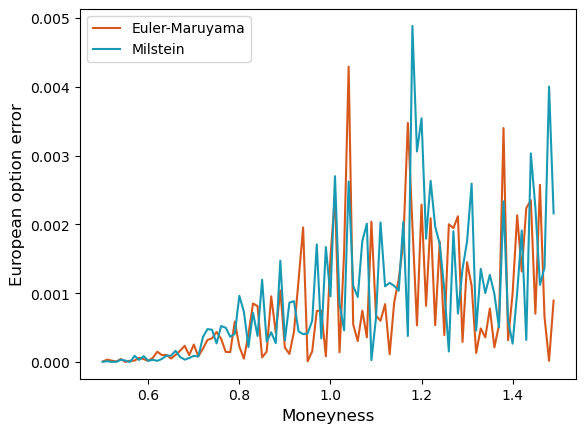

In [31]:
plt.plot(moneyness,np.abs(option_means_1 - np.array(exact_prices_1)/100), c = "#d8581c", label = "Euler-Maruyama" )
plt.plot(moneyness,np.abs(option_means_3 - np.array(exact_prices_3)/100), c = '#189ab4' , label = "Milstein" )
plt.legend(loc = "upper left")
plt.xlabel("Moneyness", fontsize = 12)
plt.ylabel("European option error", fontsize = 12)
plt.show()

We generate a similar plot for binary options.

In [32]:
exact_prices_4 = np.array([exact_price(Asset(price, 0.05, 0.2), 100, 1.0, option_type = "Binary") for price in init_prices])
montecarlo_price_samples_4 = np.array([np.array([montecarlo_price(Asset(price, 0.05, 0.2), 
                                                                  100, 1.0, N_samples = 100, option_type = "Binary",
                                                                  method = "Milstein") for price in init_prices]) for _ in range(200)])

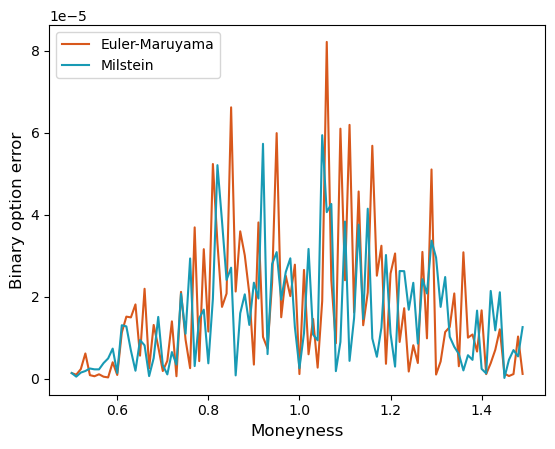

In [33]:
option_means_4 = np.mean(montecarlo_price_samples_4, axis = 0)/100
option_errors_4 = np.std(montecarlo_price_samples_4, axis = 0)/100
plt.plot(moneyness,np.abs(option_means_2 - np.array(exact_prices_2)/100), c = "#d8581c", label = "Euler-Maruyama" )
plt.plot(moneyness,np.abs(option_means_4 - np.array(exact_prices_4)/100), c = '#189ab4' , label = "Milstein" )
plt.legend(loc = "upper left")
plt.xlabel("Moneyness", fontsize = 12)
plt.ylabel("Binary option error", fontsize = 12)
plt.show()

Indeed, there is a clear distinction in the error behaviour for European and Binary options. For European options, the Monte Carlo errors grow for as the underlying's price increases. For binary options, the error is greater when the option is closer to being at the money. On the other side, there seems to be no clear advantage to using the Milstein Scheme over Euler-Maruyama. Let us create a table to quantify the errors more precisely. To this end, we create ten buckets over which the errors are averaged.

In [34]:
intervals = ["0.5 - 0.6","0.6 - 0.7", "0.7 - 0.8","0.8 - 0.9", "0.9 - 1.0", "1.0 - 1.1", "1.1 - 1.2", "1.2 - 1.3", "1.3 - 1.4", "1.4 - 1.5"]
error_intervals_1 = np.mean(np.split(option_errors_1, 10), axis = 1)
error_intervals_2 = np.mean(np.split(option_errors_2, 10), axis = 1)
error_intervals_3 = np.mean(np.split(option_errors_3, 10), axis = 1)
error_intervals_4 = np.mean(np.split(option_errors_4, 10), axis = 1)

df = pd.DataFrame({"European Euler Error": error_intervals_1,
                   "European Milstein Error": error_intervals_3,
                   "Binary Euler Error": error_intervals_2,
                   "Binary Milstein Error": error_intervals_4}, index = intervals)

df

,European Euler Error,European Milstein Error,Binary Euler Error,Binary Milstein Error
0.5 - 0.6,0.000406,0.000364,0.000043,0.000044
0.6 - 0.7,0.001484,0.001561,0.000134,0.000138
0.7 - 0.8,0.003843,0.003930,0.000276,0.000271
0.8 - 0.9,0.007577,0.007730,0.000401,0.000406
0.9 - 1.0,0.011873,0.012498,0.000472,0.000464
1.0 - 1.1,0.016819,0.016443,0.000443,0.000447
1.1 - 1.2,0.020169,0.020451,0.000386,0.000368
1.2 - 1.3,0.023852,0.023218,0.000291,0.000288
1.3 - 1.4,0.026843,0.026864,0.000211,0.000211
1.4 - 1.5,0.028309,0.028392,0.000150,0.000142


We clearly observe the difference in the dependence of the error with moneyness that we identified before.

#### 3.3 Monte Carlo accuracy and time to maturity

Having studied the performace of Monte Carlo simulations with the moneyness of the option, we now shift our focus to the time dimension. Our main objective in this section is to determine how the Monte Carlo error behaves as we change the maturity time for European and binary call options.

For each type of option, we will consider three scenarios: at-the-money (strike = 100), in-the-money (strike = 80), and out-of-the-money (strike = 120) options. In each case, we run both the Euler-Maruyama and Milstein schemes. Furthermore, to emulate a realistic setting, the number of steps used in the discretization is taken to be equal to the number of business days (years/252), so each maturity time will be simulated with a different partition.

In [35]:
# At-the-money options

# European
asset = Asset(100, 0.05, 0.2)
times = [i/252 for i in range(1,253)]
y_exact_atm_1 = [exact_price(asset, 100, time) for time in times]
y_euler_atm_1 = [montecarlo_price(asset, 100, time, 1000, steps = int(252 * time), method = "Euler") for time in times]
y_milstein_atm_1 = [montecarlo_price(asset, 100, time, 1000, steps = int(252 * time), method = "Milstein") for time in times]

# Binary
y_exact_atm_2 = [exact_price(asset, 100, time, option_type = "Binary") for time in times]
y_euler_atm_2 = [montecarlo_price(asset, 100, time, 1000, steps = int(252 * time), option_type = "Binary", method = "Euler") for time in times]
y_milstein_atm_2 = [montecarlo_price(asset, 100, time, 1000, steps = int(252 * time), option_type = "Binary", method = "Milstein") for time in times]

# In the money options

# European
y_exact_itm_1 = [exact_price(asset, 80, time) for time in times]
y_euler_itm_1 = [montecarlo_price(asset, 80, time, 1000, steps = int(252 * time), method = "Euler") for time in times]
y_milstein_itm_1 = [montecarlo_price(asset, 80, time, 1000, steps = int(252 * time), method = "Milstein") for time in times]

# Binary
y_exact_itm_2 = [exact_price(asset, 80, time, option_type = "Binary") for time in times]
y_euler_itm_2 = [montecarlo_price(asset, 80, time, 1000, steps = int(252 * time), option_type = "Binary", method = "Euler") for time in times]
y_milstein_itm_2 = [montecarlo_price(asset, 80, time, 1000, steps = int(252 * time), option_type = "Binary", method = "Milstein") for time in times]

# Out of the money options

# European
y_exact_otm_1 = [exact_price(asset, 120, time) for time in times]
y_euler_otm_1 = [montecarlo_price(asset, 120, time, 1000, steps = int(252 * time), method = "Euler") for time in times]
y_milstein_otm_1 = [montecarlo_price(asset, 120, time, 1000, steps = int(252 * time), method = "Milstein") for time in times]

# Binary
y_exact_otm_2 = [exact_price(asset, 120, time, option_type = "Binary") for time in times]
y_euler_otm_2 = [montecarlo_price(asset, 120, time, 1000, steps = int(252 * time), option_type = "Binary", method = "Euler") for time in times]
y_milstein_otm_2 = [montecarlo_price(asset, 120, time, 1000, steps = int(252 * time), option_type = "Binary", method = "Milstein") for time in times]

We plot the simulations for an exploratory data analysis.

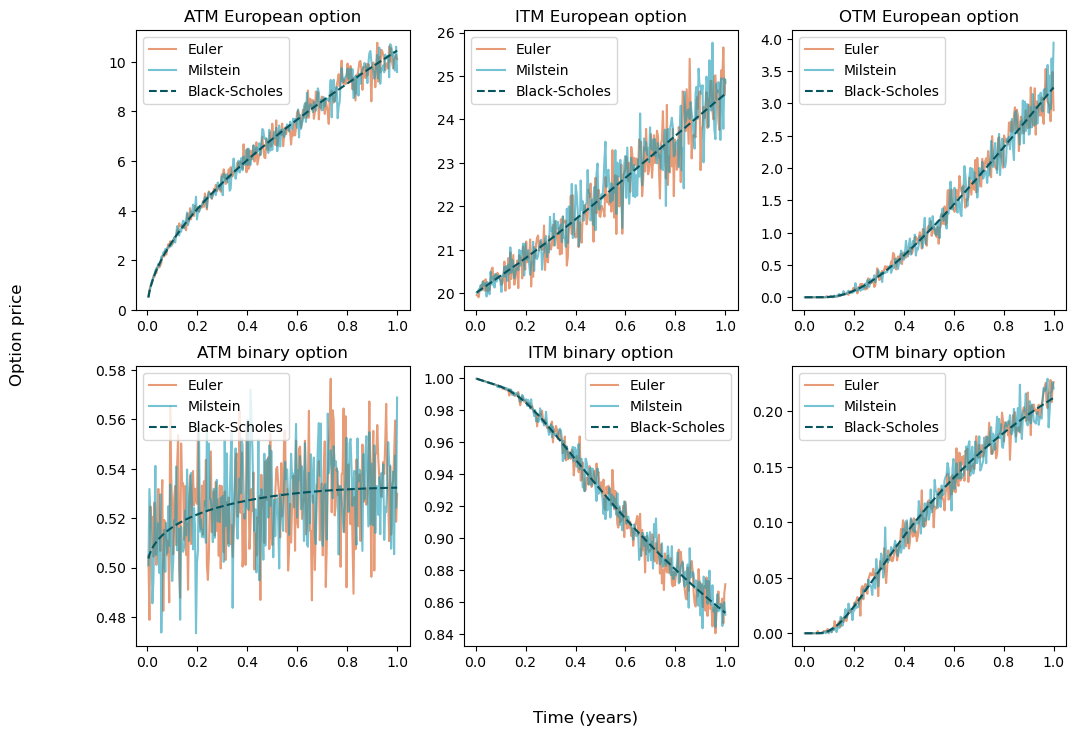

In [36]:

fig, ((ax_atm_1, ax_itm_1, ax_otm_1), (ax_atm_2, ax_itm_2, ax_otm_2)) = plt.subplots(2, 3, figsize = (12,8))

ax_atm_1.plot(times, y_euler_atm_1, c = "#d8581c", alpha = 0.6, label = "Euler")
ax_atm_1.plot(times, y_milstein_atm_1, c = "#189ab4", alpha = 0.6, label = "Milstein")
ax_atm_1.plot(times, y_exact_atm_1, '--', c = "#05545e", label = "Black-Scholes" )
ax_atm_1.title.set_text("ATM European option")
ax_atm_1.legend(loc = "upper left")

fig.supxlabel("Time (years)", fontsize = 12)
fig.supylabel("Option price", fontsize = 12)

ax_atm_2.plot(times, y_euler_atm_2, c = "#d8581c", alpha = 0.6, label = "Euler")
ax_atm_2.plot(times, y_milstein_atm_2, c = "#189ab4", alpha = 0.6, label = "Milstein")
ax_atm_2.plot(times, y_exact_atm_2, '--', c = "#05545e", label = "Black-Scholes")
ax_atm_2.title.set_text("ATM binary option")
ax_atm_2.legend(loc = "upper left")

ax_itm_1.plot(times, y_euler_itm_1, c = "#d8581c", alpha = 0.6, label = "Euler")
ax_itm_1.plot(times, y_milstein_itm_1, c = "#189ab4", alpha = 0.6, label = "Milstein")
ax_itm_1.plot(times, y_exact_itm_1, '--', c = "#05545e", label = "Black-Scholes")
ax_itm_1.title.set_text("ITM European option")
ax_itm_1.legend(loc = "upper left")

ax_itm_2.plot(times, y_euler_itm_2, c = "#d8581c", alpha = 0.6, label = "Euler")
ax_itm_2.plot(times, y_milstein_itm_2, c = "#189ab4", alpha = 0.6, label = "Milstein")
ax_itm_2.plot(times, y_exact_itm_2, '--', c = "#05545e", label = "Black-Scholes")
ax_itm_2.title.set_text("ITM binary option")
ax_itm_2.legend(loc = "upper right")

ax_otm_1.plot(times, y_euler_otm_1, c = "#d8581c", alpha = 0.6, label = "Euler" )
ax_otm_1.plot(times, y_milstein_otm_1, c = "#189ab4", alpha = 0.6, label = "Milstein")
ax_otm_1.plot(times, y_exact_otm_1, '--', c = "#05545e", label = "Black-Scholes")
ax_otm_1.title.set_text("OTM European option")
ax_otm_1.legend(loc = "upper left")

ax_otm_2.plot(times, y_euler_otm_2, c = "#d8581c", alpha = 0.6, label = "Euler")
ax_otm_2.plot(times, y_milstein_otm_2, c = "#189ab4", alpha = 0.6, label = "Milstein")
ax_otm_2.plot(times, y_exact_otm_2, '--', c = "#05545e", label = "Black-Scholes")
ax_otm_2.title.set_text("OTM binary option")
ax_otm_2.legend(loc = "upper left")

plt.show()

For European options, in all three scenarios, errors seem to grow for a larger maturity time. The same can be observed for in the money and out of the money binary options. However, the error seems to be fairly constant for the at-the-money case. Additionally, using the Milstein methods seems to have no added benefit.

Let us verify these observations by estimating the errors as a function of the maturity time. To expedite the error analysis, we will calculate error in a simplified manner: we divide the period into ten time buckets and add find the average of the estimation error made in each of them.

Text(0.02, 0.5, 'Option price error')

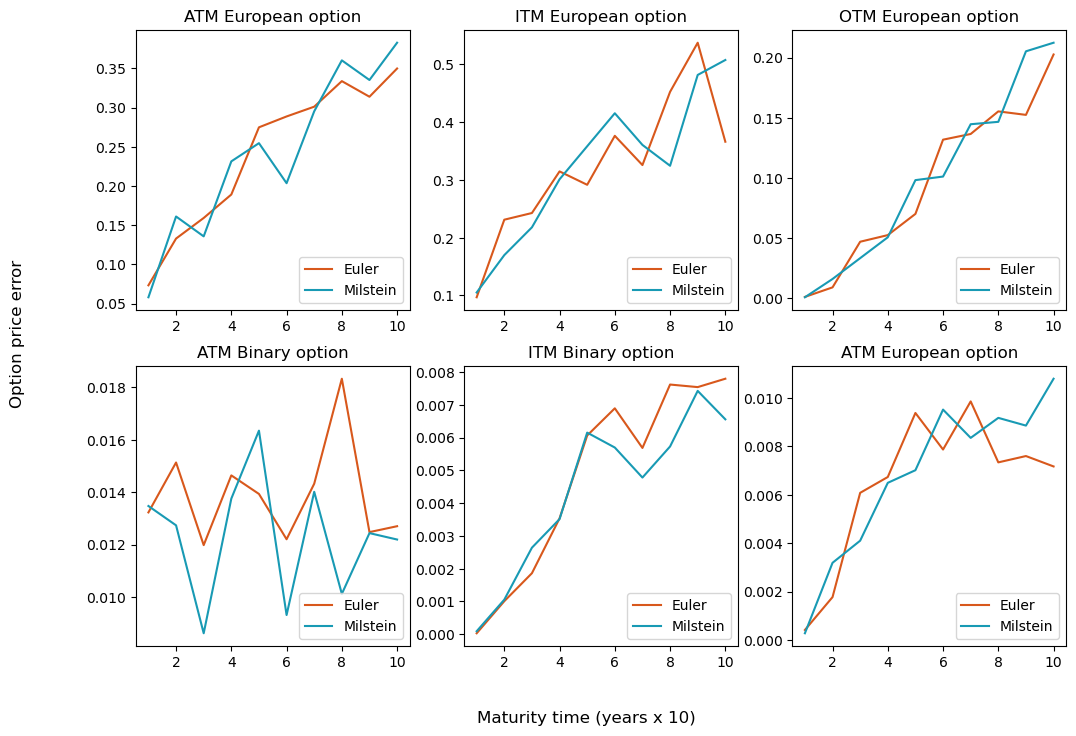

In [37]:
fig, ((err_atm_1, err_itm_1, err_otm_1), (err_atm_2, err_itm_2, err_otm_2)) = plt.subplots(2, 3, figsize = (12,8))

error_euler_atm_1 = np.abs(np.array(y_euler_atm_1) - np.array(y_exact_atm_1))
error_milstein_atm_1 = np.abs(np.array(y_milstein_atm_1) - np.array(y_exact_atm_1))
err_atm_1.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_euler_atm_1, 10))), c = "#d8581c", label = "Euler")
err_atm_1.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_milstein_atm_1, 10))), c = "#189ab4", label = "Milstein")
err_atm_1.title.set_text("ATM European option")
err_atm_1.legend(loc = "lower right")

error_euler_atm_2 = np.abs(np.array(y_euler_atm_2) - np.array(y_exact_atm_2))
error_milstein_atm_2 = np.abs(np.array(y_milstein_atm_2) - np.array(y_exact_atm_2))
err_atm_2.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_euler_atm_2, 10))), c = "#d8581c", label = "Euler")
err_atm_2.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_milstein_atm_2, 10))), c = "#189ab4", label = "Milstein")
err_atm_2.title.set_text("ATM Binary option")
err_atm_2.legend(loc = "lower right")

error_euler_itm_1 = np.abs(np.array(y_euler_itm_1) - np.array(y_exact_itm_1))
error_milstein_itm_1 = np.abs(np.array(y_milstein_itm_1) - np.array(y_exact_itm_1))
err_itm_1.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_euler_itm_1, 10))), c = "#d8581c", label = "Euler")
err_itm_1.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_milstein_itm_1, 10))), c = "#189ab4", label = "Milstein")
err_itm_1.title.set_text("ITM European option")
err_itm_1.legend(loc = "lower right")


error_euler_itm_2 = np.abs(np.array(y_euler_itm_2) - np.array(y_exact_itm_2))
error_milstein_itm_2 = np.abs(np.array(y_milstein_itm_2) - np.array(y_exact_itm_2))
err_itm_2.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_euler_itm_2, 10))), c = "#d8581c", label = "Euler")
err_itm_2.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_milstein_itm_2, 10))), c = "#189ab4", label = "Milstein")
err_itm_2.title.set_text("ITM Binary option")
err_itm_2.legend(loc = "lower right")

error_euler_otm_1 = np.abs(np.array(y_euler_otm_1) - np.array(y_exact_otm_1))
error_milstein_otm_1 = np.abs(np.array(y_milstein_otm_1) - np.array(y_exact_otm_1))
err_otm_1.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_euler_otm_1, 10))), c = "#d8581c", label = "Euler")
err_otm_1.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_milstein_otm_1, 10))), c = "#189ab4", label = "Milstein")
err_otm_1.title.set_text("OTM European option")
err_otm_1.legend(loc = "lower right")

error_euler_otm_2 = np.abs(np.array(y_euler_otm_2) - np.array(y_exact_otm_2))
error_milstein_otm_2 = np.abs(np.array(y_milstein_otm_2) - np.array(y_exact_otm_2))
err_otm_2.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_euler_otm_2, 10))), c = "#d8581c", label = "Euler")
err_otm_2.plot(np.arange(1,11,1),list(map(np.mean,np.array_split(error_milstein_otm_2, 10))), c = "#189ab4", label = "Milstein")
err_otm_2.title.set_text("ATM European option")
err_otm_2.legend(loc = "lower right")

fig.supxlabel("Maturity time (years x 10)", fontsize = 12)
fig.supylabel("Option price error", fontsize = 12)


This further confirms the suspected behaviour, with no observed significant different between the Euler and Milstein schemes. At present, we have not found any intuitive explanation for why the error in at-the-money binary options does not grow with maturity time. This observation is left for further exploration.

## 4. The effects of volatility and risk-free rate

In this section, we focus on varying the parameters of the underlying, as opposed to the call option features, and study how they affect the
accuracy of the numerical methods for option price simulation

#### 4.1 Volatility

We start by analyzing the dependence of the Monte Carlo error on volatility, considering a range of annualized volatilities between $5\%$ and $55\%$. This time, the analysis focuses only on at-the-money European and binary options where the initial asset price and the strike are equal to $100.$ Let us first visualize how the option prices vary with volatility. The script below generates 200 sample option prices for each volatility in the chosen range.

In [38]:
vols = np.arange(0.05, 0.55, 0.01)
exact_prices_vols_1 = np.array([exact_price(Asset(100, 0.05, vol), 100, 1.0) for vol in vols])
montecarlo_price_samples_vols_1 = np.array([np.array([montecarlo_price(Asset(100, 0.05, vol), 100, 1.0, 
                                                                       N_samples = 100) for vol in vols]) for _ in range(200)])
montecarlo_price_samples_vols_2 = np.array([np.array([montecarlo_price(Asset(100, 0.05, vol), 100, 1.0, N_samples = 100,
                                                                       method='Milstein') for vol in vols]) for _ in range(200)])

Next, we calculate the estimated option price and the simulation errors for both the Milstein and Euler methods.

In [39]:
option_means_vols_1 = np.mean(montecarlo_price_samples_vols_1, axis = 0)
option_errors_vols_1 = np.std(montecarlo_price_samples_vols_1, axis = 0)
option_means_vols_2 = np.mean(montecarlo_price_samples_vols_2, axis = 0)
option_errors_vols_2 = np.std(montecarlo_price_samples_vols_2, axis = 0)

We proceed to plot the spread of option prices around the exact result given by the Black-Scholes formula

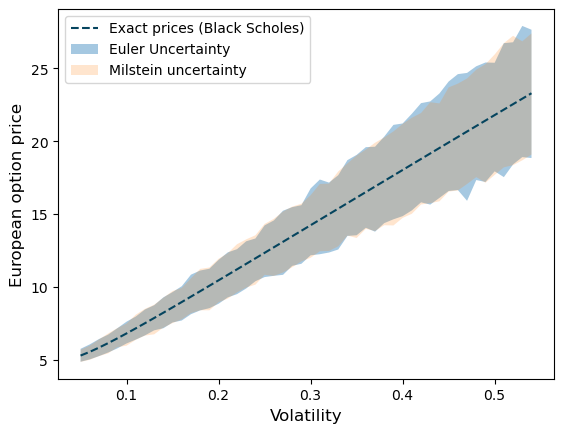

In [40]:
fig, ax = plt.subplots()
ax.plot(vols, np.array(exact_prices_vols_1), '--', c = '#05445e', label = "Exact prices (Black Scholes)")
ax.fill_between(vols, option_means_vols_1 + option_errors_vols_1, option_means_vols_1 - option_errors_vols_1, alpha = 0.4, label = "Euler Uncertainty")
ax.fill_between(vols, option_means_vols_2 + option_errors_vols_2, option_means_vols_2 - option_errors_vols_2, alpha = 0.2, label = "Milstein uncertainty")
plt.legend(loc='upper left')
plt.xlabel("Volatility", fontsize = 12)
plt.ylabel("European option price", fontsize = 12)
plt.show()

We observe that the spread grows as the volatility increases. We proceed in the same way for binary options.

In [41]:
exact_prices_vols_3 = np.array([exact_price(Asset(100, 0.05, vol), 100, 1.0, option_type = "Binary") for vol in vols])
montecarlo_price_samples_vols_3 = np.array([np.array([montecarlo_price(Asset(100, 0.05, vol), 100, 1.0, N_samples = 100, 
                                                                       option_type = "Binary") for vol in vols]) for _ in range(200)])
montecarlo_price_samples_vols_4 = np.array([np.array([montecarlo_price(Asset(100, 0.05, vol), 100, 1.0, N_samples = 100, option_type = "Binary",
                                                                       method='Milstein') for vol in vols]) for _ in range(200)])

In [42]:
option_means_vols_3 = np.mean(montecarlo_price_samples_vols_3, axis = 0)
option_errors_vols_3 = np.std(montecarlo_price_samples_vols_3, axis = 0)
option_means_vols_4 = np.mean(montecarlo_price_samples_vols_4, axis = 0)
option_errors_vols_4 = np.std(montecarlo_price_samples_vols_4, axis = 0)

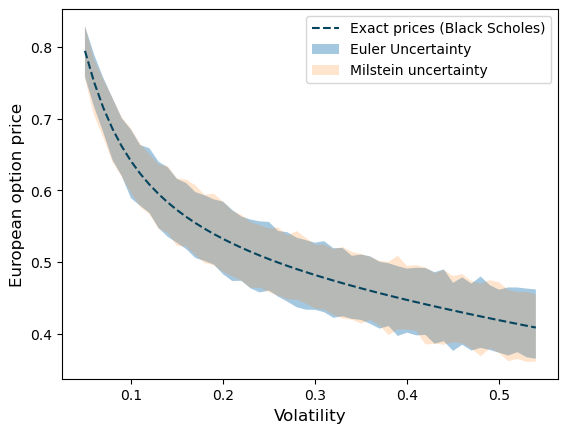

In [43]:
fig, ax = plt.subplots()
ax.plot(vols, np.array(exact_prices_vols_3), '--', c = '#05445e', label = "Exact prices (Black Scholes)")
ax.fill_between(vols, option_means_vols_3 + option_errors_vols_3, option_means_vols_3 - option_errors_vols_3, alpha = 0.4, label = "Euler Uncertainty")
ax.fill_between(vols, option_means_vols_4 + option_errors_vols_4, option_means_vols_4 - option_errors_vols_4, alpha = 0.2, label = "Milstein uncertainty")
plt.legend(loc='upper right')
plt.xlabel("Volatility", fontsize = 12)
plt.ylabel("European option price", fontsize = 12)
plt.show()

In this case, the spread seems to reach a constant value as the volatility increases. Let us plot the errors to study this behaviour more closely.

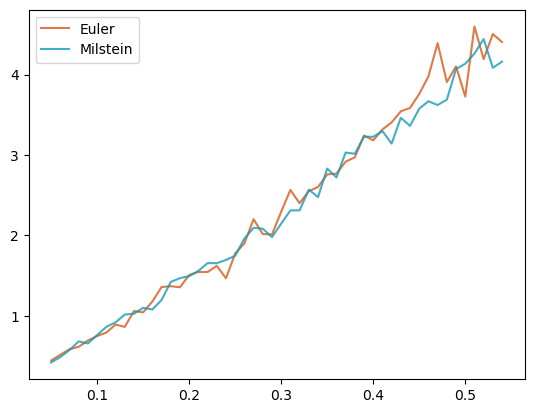

In [44]:
plt.plot(vols, option_errors_vols_1, '-', c = "#d8581c", alpha = 0.8, label = "Euler")
plt.plot(vols, option_errors_vols_2, '-', c = "#189ab4", alpha = 0.8, label = "Milstein")
plt.legend(loc='upper left')
plt.show()

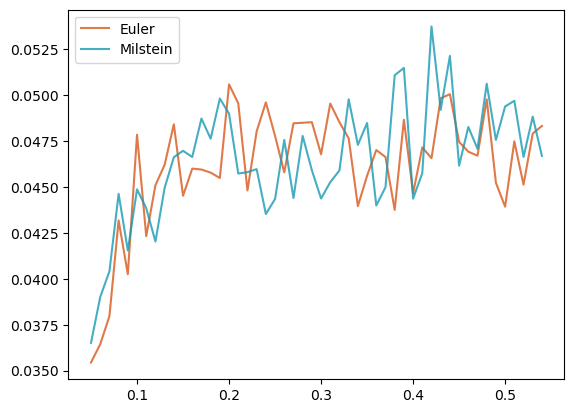

In [45]:
plt.plot(vols, option_errors_vols_3, '-', c = "#d8581c", alpha = 0.8, label = "Euler")
plt.plot(vols, option_errors_vols_4, '-', c = "#189ab4", alpha = 0.8, label = "Milstein")
plt.legend(loc='upper left')
plt.show()

We can also build a table to inspect the precise values

In [46]:
intervals = ["0.05 - 0.10","0.10 - 0.15", "0.15 - 0.20","0.20 - 0.25", "0.25 - 0.30", "0.30 - 0.35", "0.35 - 0.40", "0.40 - 0.45", "0.45 - 0.50", "0.50 - 0.55"]
error_intervals_1 = np.mean(np.split(option_errors_vols_1, 10), axis = 1)
error_intervals_2 = np.mean(np.split(option_errors_vols_2, 10), axis = 1)
error_intervals_3 = np.mean(np.split(option_errors_vols_3, 10), axis = 1)
error_intervals_4 = np.mean(np.split(option_errors_vols_4, 10), axis = 1)

df = pd.DataFrame({"European Euler Error": error_intervals_1,
                   "European Milstein Error": error_intervals_2,
                   "Binary Euler Error": error_intervals_3,
                   "Binary Milstein Error": error_intervals_4}, index = intervals)

df

,European Euler Error,European Milstein Error,Binary Euler Error,Binary Milstein Error
0.05 - 0.10,0.569883,0.563242,0.038652,0.040412
0.10 - 0.15,0.869941,0.916078,0.045962,0.044452
0.15 - 0.20,1.259761,1.252177,0.045535,0.047937
0.20 - 0.25,1.536417,1.610762,0.048500,0.045991
0.25 - 0.30,1.980309,1.971781,0.047796,0.045986
0.30 - 0.35,2.481640,2.362201,0.047274,0.046506
0.35 - 0.40,2.930541,2.964061,0.046318,0.047989
0.40 - 0.45,3.405582,3.297183,0.047636,0.049020
0.45 - 0.50,4.026314,3.723557,0.047200,0.047921
0.50 - 0.55,4.284352,4.215441,0.046540,0.048229


Indeed, for at-the-money binary options, the error is constant with volatilty. The fundamental cause of this behaviour is that the payoff of the option does not depend on the final price of the underlying asset. Instead, the payoff is constant. Therefore, any error in the estimation of the asset price at maturity will cause a similar error in the computed option price.

#### 4.2 Interest rate

Finally, we explore the scaling of option errors with varying risk-free rates. We proceed in the same way we did with volatility, considering only at-the-money European and binary options. We consider risk free rates between $1\%$ and $20\%.$

In [47]:
rates = np.arange(0.01, 0.2, 0.01)
exact_prices_rates_1 = np.array([exact_price(Asset(100, rate, 0.2), 100, 1.0) for rate in rates])
montecarlo_price_samples_rates_1 = np.array([np.array([montecarlo_price(Asset(100, rate, 0.2), 100, 1.0, 
                                                                        N_samples = 100) for rate in rates]) for _ in range(200)])
montecarlo_price_samples_rates_2 = np.array([np.array([montecarlo_price(Asset(100, rate, 0.2), 100, 1.0, N_samples = 100,
                                                                       method='Milstein') for rate in rates]) for _ in range(200)])

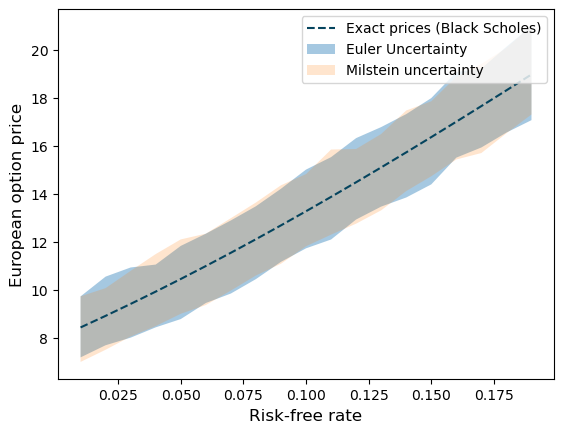

In [48]:
option_means_rates_1 = np.mean(montecarlo_price_samples_rates_1, axis = 0)
option_errors_rates_1 = np.std(montecarlo_price_samples_rates_1, axis = 0)
option_means_rates_2 = np.mean(montecarlo_price_samples_rates_2, axis = 0)
option_errors_rates_2 = np.std(montecarlo_price_samples_rates_2, axis = 0)

fig, ax = plt.subplots()
ax.plot(rates, np.array(exact_prices_rates_1), '--', c = '#05445e', label = "Exact prices (Black Scholes)")
ax.fill_between(rates, option_means_rates_1 + option_errors_rates_1, option_means_rates_1 - option_errors_rates_1, alpha = 0.4, label = "Euler Uncertainty")
ax.fill_between(rates, option_means_rates_2+ option_errors_rates_2, option_means_rates_2 - option_errors_rates_2, alpha = 0.2, label = "Milstein uncertainty")
plt.legend(loc='upper right')
plt.xlabel("Risk-free rate", fontsize = 12)
plt.ylabel("European option price", fontsize = 12)
plt.show()

In [49]:
exact_prices_rates_3 = np.array([exact_price(Asset(100, rate, 0.2), 100, 1.0, option_type="Binary") for rate in rates])
montecarlo_price_samples_rates_3 = np.array([np.array([montecarlo_price(Asset(100, rate, 0.2), 100, 1.0, N_samples = 100, 
                                                                        option_type = "Binary") for rate in rates]) for _ in range(200)])
montecarlo_price_samples_rates_4 = np.array([np.array([montecarlo_price(Asset(100, rate, 0.2), 100, 1.0, N_samples = 100,
                                                                       method='Milstein', option_type="Binary") for rate in rates])
                                             for _ in range(200)])

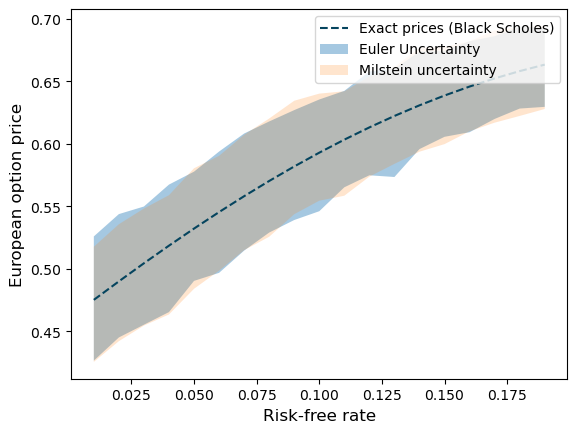

In [50]:
option_means_rates_3 = np.mean(montecarlo_price_samples_rates_3, axis = 0)
option_errors_rates_3 = np.std(montecarlo_price_samples_rates_3, axis = 0)
option_means_rates_4 = np.mean(montecarlo_price_samples_rates_4, axis = 0)
option_errors_rates_4 = np.std(montecarlo_price_samples_rates_4, axis = 0)


fig, ax = plt.subplots()
#ax.plot(vols, option_means_vols_1, '-', c = "#d8581c", alpha = 0.8, label = "Monte Carlo (Euler)")
ax.plot(rates, np.array(exact_prices_rates_3), '--', c = '#05445e', label = "Exact prices (Black Scholes)")
ax.fill_between(rates, option_means_rates_3 + option_errors_rates_3, option_means_rates_3 - option_errors_rates_3, alpha = 0.4, label = "Euler Uncertainty")
ax.fill_between(rates, option_means_rates_4+ option_errors_rates_4, option_means_rates_4 - option_errors_rates_4, alpha = 0.2, label = "Milstein uncertainty")
plt.legend(loc='upper right')
plt.xlabel("Risk-free rate", fontsize = 12)
plt.ylabel("European option price", fontsize = 12)
plt.show()

In either case, the errors seem to be constant as the rate increases. Indeed, isolating the errors and plotting them as a function of the rate, we obtain the figures shown below.

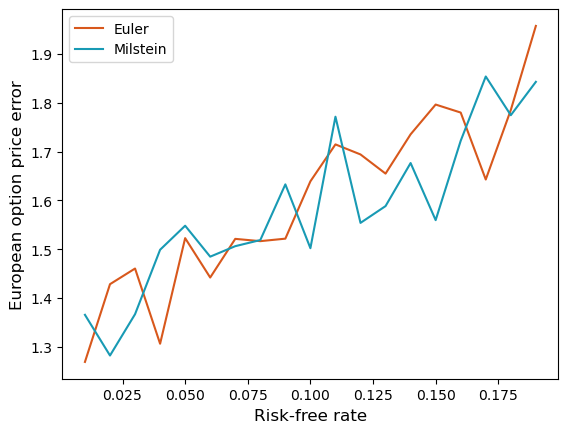

In [51]:
plt.plot(rates, option_errors_rates_1, '-', c = "#d8581c", label = "Euler")
plt.plot(rates, option_errors_rates_2, '-', c = "#189ab4", label = "Milstein")
plt.legend(loc='upper left')
plt.xlabel("Risk-free rate", fontsize = 12)
plt.ylabel("European option price error", fontsize = 12)
plt.show()

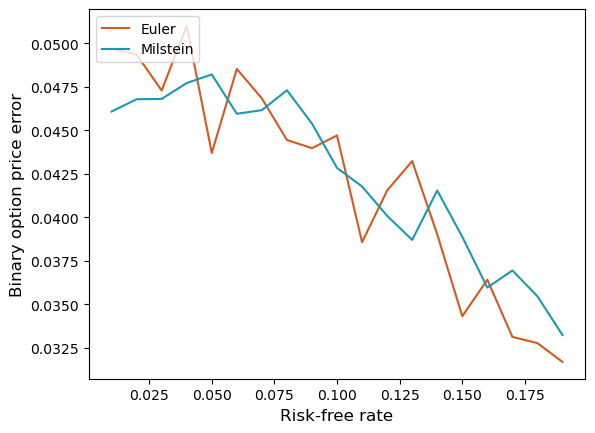

In [52]:
plt.plot(rates, option_errors_rates_3, '-', c = "#d8581c", label = "Euler")
plt.plot(rates, option_errors_rates_4, '-', c = "#189ab4", label = "Milstein")
plt.legend(loc='upper left')
plt.xlabel("Risk-free rate", fontsize = 12)
plt.ylabel("Binary option price error", fontsize = 12)
plt.show()

Interestingly, the error plots show a behaviour that could not be easily observed preliminarily. For European options, the error increases as the interest rate increases. However, we observe the opposite behaviour for binary options.

## 5. Conclusion

In this report, we simulated asset paths using the Euler-Maruyama and Milstein schemes, and used the resulting distribution of underlying asset values at maturity to determine the fair European and binary call options. In section 2, the Milstein method was found to have a higher order of converence and was shown to be a better predictor of the standard deviation of the resulting distribution.

However, in sections 3 and 4, these improvements were not reflected in the calculation of option prices. Since option prices are calculated using the discounted expectation value of the payoffs, it is possible that the order of convergence is further decreased. The root of this observation might lie in the fact that we assumed that the percentage volatility is a constant. Since the Milstein method relies on the first derivative of such parameter, it is possible that the improvements be more prominent when using non-linear or stochastic volatility models.


For the error of the numerical methods considered, we did not observe any unexpected behaviour for European call options. In this case, the errors scaled up with moneyness, time to maturity, volatility, and risk free rate.
Binary options, on the other side, exhibited more exotic behaviour. Numerical simulation tend to have a higher variability when pricing at-the-money binary call options, but are more robust when they are in or out of the money. In constrast with European options, the errors were constant with both time to expiry and volatility. The behaviour is expected to be similar, since the variance of the asset prices at time $T$ depends on $\sigma^2 T$. Finally, the error for at-the-money European and binary options showcased opposite behaviours for increasing interest rates. Indeed, for European options, an interest rate closed to zero would yield a payoff of zero for half of the samples, decreasing the variance. For binary options, a high rate would increase the likelihood of a payoff equal to $1$, decreasing variability.

The current observations are limited by computational power and floating point accuracy. Using GPUs or lower-level programming languages could help improve the precision of our results. However, we must note that such resource may not be necessary if our current methods price the options succesfully to the nearest cent.

Future studies could focus on more complex models for the underlying asset in order to verify the hypothesis that the Milstein method yields a better advantage in such cases. Additionally, more kinds of exotic options could be considered, specifically to study the behaviour of at-the-money options, since there seems to be higher variability in this regime.

## 6. References

[1] Blyth, S. (2014). An introduction to quantitative finance. Oxford University Press.

[2] Shreve, S. E. (2005). Stochastic calculus for finance 1, the binomial asset pricing model. Springer.

[3] Jackel P. (2002). Monte Carlo methods in finance. Wiley Finance Series.

[4] Log-norma distribution in Wikipedia (2025, April 23), https://en.wikipedia.org/wiki/Log-normal_distribution